
# PET TOF listmode projector

In this example we will show how to setup and use a TOF 
PET listmode projector including geometrical forward projection
in listmode, image-based resolution model and a listmode 
attenuation model.

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [2]:
# import array_api_compat.numpy as xp

import array_api_compat.cupy as xp
# import array_api_compat.torch as xp
import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    dev = "cuda"


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /home/pablo/.conda/envs/recon/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /home/pablo/.conda/envs/recon/lib/libparallelproj_cuda.so.1.8.0
    


setup a regular polygon PET scanner



In [6]:
num_rings = 300
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=300.0,
    num_sides=24,
    num_lor_endpoints_per_side=20,
    lor_spacing=4,
    ring_positions=xp.linspace(-150, 150, num_rings),
    symmetry_axis=1,
)

## Show the scanner geometry and the events



/tmp/ipykernel_2265687/2262300169.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


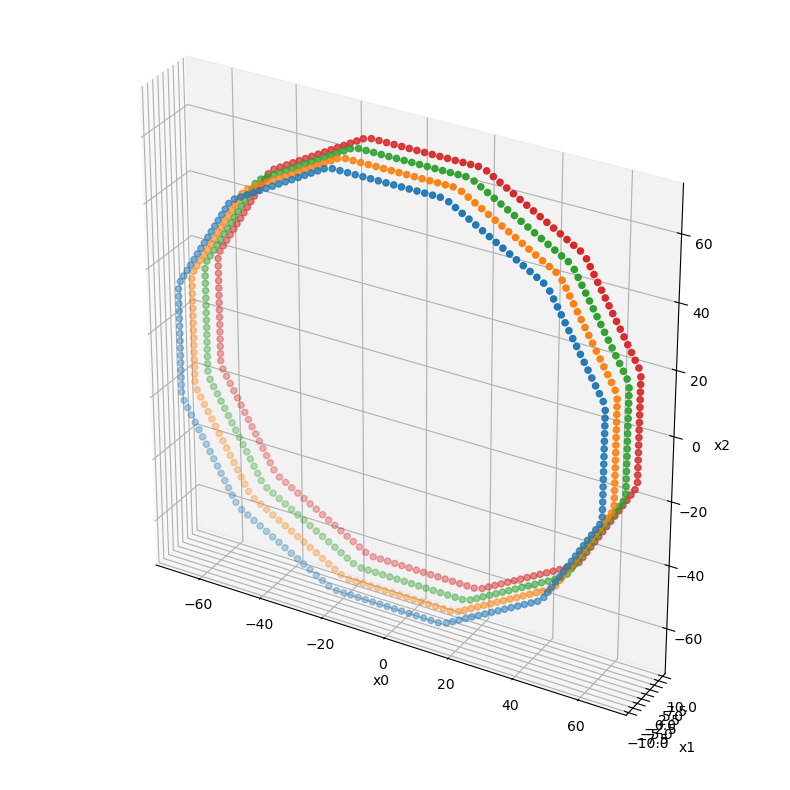

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
scanner.show_lor_endpoints(ax)
fig.tight_layout()
fig.show()

## Setup a TOF listmode projector and a test image



In [ ]:
img_shape = (40, 9, 40)
voxel_size = (2.0, 3.0, 2.0)

lm_proj = parallelproj.ListmodePETProjector(
    event_start_coordinates, event_end_coordinates, img_shape, voxel_size
)

# set the TOF parameters
lm_proj.tof_parameters = tof_params
# set the event TOF bins
lm_proj.event_tofbins = event_tof_bins
# enable TOF
lm_proj.tof = True

x = xp.ones(img_shape, dtype=xp.float32, device=dev)

## Perform listmode forward and back projections



In [ ]:
x_fwd = lm_proj(x)
print(x_fwd)

# back project a list of ones
ones_list = xp.ones(lm_proj.num_events, dtype=xp.float32, device=dev)
y_back = lm_proj.adjoint(ones_list)

## Show the backprojected list of ones (events)



In [ ]:
fig2, ax2 = plt.subplots(3, 3, figsize=(8, 8))
vmax = float(xp.max(y_back))
for i in range(ax2.size):
    if i < y_back.shape[1]:
        axx = ax2.ravel()[i]
        axx.imshow(
            parallelproj.to_numpy_array(y_back[:, i, :].T),
            cmap="Greys",
            vmin=0,
            vmax=vmax,
        )
        axx.set_title(f"img plane {i}", fontsize="medium")
    else:
        ax2.ravel()[i].set_axis_off()
fig2.tight_layout()
fig2.show()

## Combine the listmode projector with a resolution and attenuation model



In [ ]:
# setup a simple image-based resolution model with an Gaussian FWHM of 4.5mm
res_model = parallelproj.GaussianFilterOperator(
    lm_proj.in_shape, sigma=4.5 / (2.35 * lm_proj.voxel_size)
)

# define arbritrary attenuation factors
att_list = xp.asarray([0.3, 0.4, 0.2, 0.6], device=dev)
att_op = parallelproj.ElementwiseMultiplicationOperator(att_list)


lm_proj_with_res_model_and_att = parallelproj.CompositeLinearOperator(
    (att_op, lm_proj, res_model)
)

x_fwd2 = lm_proj_with_res_model_and_att(x)
print(x_fwd2)

y_back2 = lm_proj_with_res_model_and_att.adjoint(ones_list)

## Show the backprojected list of ones (events)



In [ ]:
fig3, ax3 = plt.subplots(3, 3, figsize=(8, 8))
vmax = float(xp.max(y_back2))
for i in range(ax3.size):
    if i < y_back.shape[1]:
        axx = ax3.ravel()[i]
        axx.imshow(
            parallelproj.to_numpy_array(y_back2[:, i, :].T),
            cmap="Greys",
            vmin=0,
            vmax=vmax,
        )
        axx.set_title(f"img plane {i}", fontsize="medium")
    else:
        ax3.ravel()[i].set_axis_off()
fig3.tight_layout()
fig3.show()